# Exact DKL (Deep Kernel Learning) Regression w/ KISS-GP

## Overview

In this notebook, we'll give a brief tutorial on how to use deep kernel learning for regression on a medium scale dataset using SKI. This also demonstrates how to incorporate standard PyTorch modules in to a Gaussian process model. 

In [30]:
import math
import tqdm
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

## Loading Data

For this example notebook, we'll be using the `elevators` UCI dataset used in the paper. Running the next cell downloads a copy of the dataset that has already been scaled and normalized appropriately. For this notebook, we'll simply be splitting the data using the first 80% of the data as training and the last 20% as testing.

**Note**: Running the next cell will attempt to download a ~400 KB dataset file to the current directory.

In [31]:
import torch
import pickle
import torch

class ODDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        data_dict = pickle.load(open(path, "rb"))
        df = data_dict["df"]
        self.X = torch.from_numpy(data_dict["X_embedded"]).to(dtype=torch.float64)
        self.meta = torch.from_numpy(df["OD"].values).to(dtype=torch.float64)
        self.y = torch.from_numpy(df["norm_TSNAK"].values).to(dtype=torch.float64)        
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]
    def __len__(self):
        assert len(self.X) == len(self.y), "X and y have different lengths"
        return len(self.X)

In [32]:
import urllib.request
import os
from scipy.io import loadmat
from math import floor


# this is for running the notebook in our testing framework
smoke_test = True

oddata = ODDataset(path=r'.\data_set_dict.pkl')
X = oddata.X
y = oddata.y

#random split
torch.manual_seed(0)
perm = torch.randperm(len(X))
X = X[perm]
y = y[perm]

train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

KeyError: 'X_embedded'

## Defining the DKL Feature Extractor

Next, we define the neural network feature extractor used to define the deep kernel. In this case, we use a fully connected network with the architecture `d -> 1000 -> 500 -> 50 -> 2`, as described in the original DKL paper. All of the code below uses standard PyTorch implementations of neural network layers.

In [ ]:
data_dim = train_x.size(-1)

class LargeFeatureExtractor(torch.nn.Sequential):           
    def __init__(self):                                      
        super(LargeFeatureExtractor, self).__init__()        
        self.add_module('linear1', torch.nn.Linear(data_dim, data_dim//2))
        self.add_module('relu1', torch.nn.ReLU())                  
        self.add_module('linear2', torch.nn.Linear(data_dim//2, data_dim//4))     
        self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear3', torch.nn.Linear(data_dim//4, 2))       
        # self.add_module('relu3', torch.nn.ReLU())                  
        # self.add_module('linear4', torch.nn.Linear(50, 2))         
                                                             
feature_extractor = LargeFeatureExtractor()

## Defining the DKL-GP Model

We now define the GP model. For more details on the use of GP models, see our simpler examples. This model uses a `GridInterpolationKernel` (SKI) with an RBF base kernel. 

### The forward method

In deep kernel learning, the forward method is where most of the interesting new stuff happens. Before calling the mean and covariance modules on the data as in the simple GP regression setting, we first pass the input data `x` through the neural network feature extractor. Then, to ensure that the output features of the neural network remain in the grid bounds expected by SKI, we scales the resulting features to be between 0 and 1.

Only after this processing do we call the mean and covariance module of the Gaussian process. This example also demonstrates the flexibility of defining GP models that allow for learned transformations of the data (in this case, via a neural network) before calling the mean and covariance function. Because the neural network in this case maps to two final output features, we will have no problem using SKI.

In [ ]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, feature_extractor=torch.nn.Identity()):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor
            
            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"
        
            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().double()
model = GPRegressionModel(train_x, train_y, likelihood, feature_extractor).double()


if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

### Training the model

The cell below trains the DKL model above, learning both the hyperparameters of the Gaussian process **and** the parameters of the neural network in an end-to-end fashion using Type-II MLE. We run 20 iterations of training using the `Adam` optimizer built in to PyTorch. With a decent GPU, this should only take a few seconds.

In [ ]:
training_iterations = 600

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i in iterator:
        model.train()
        likelihood.train()
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()
        
        if i % 2 == 0:
            model.eval()
            likelihood.eval()
            with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
                preds = model(test_x)
            print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))
        
%time train()

  0%|          | 0/600 [00:00<?, ?it/s]

Test MAE: 2.95461639673252
Test MAE: 2.968745941437146
Test MAE: 2.975466943220989
Test MAE: 2.952595539529787
Test MAE: 2.9623922366231463
Test MAE: 2.965346649121619
Test MAE: 3.016945081478327
Test MAE: 3.0902527127984554
Test MAE: 3.1069691845442327
Test MAE: 3.103242592738155
Test MAE: 3.0866777233340192
Test MAE: 3.091094984256549
Test MAE: 3.1303334363452953
Test MAE: 3.154642528731183
Test MAE: 3.184677985832493
Test MAE: 3.1741227019785643
Test MAE: 3.1476433329710862
Test MAE: 3.1193806325568194
Test MAE: 3.1236212641418577
Test MAE: 3.1009427290646854
Test MAE: 3.131080173512562
Test MAE: 3.139327018548727
Test MAE: 3.1581235747580614
Test MAE: 3.168227590851447
Test MAE: 3.2016671525253253
Test MAE: 3.226586528277913
Test MAE: 3.268343340080466
Test MAE: 3.2764343843848427
Test MAE: 3.305226315097454
Test MAE: 3.3458571045263548
Test MAE: 3.431735666039927
Test MAE: 3.483635566265528
Test MAE: 3.3250887781074434
Test MAE: 3.2290392174677063
Test MAE: 3.4917708842594717
Test

KeyboardInterrupt: 

### Making Predictions

The next cell gets the predictive covariance for the test set (and also technically gets the predictive mean, stored in `preds.mean()`) using the standard SKI testing code, with no acceleration or precomputation. 

In [ ]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(test_x)
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))

Test MAE: 3.258994329238302


In [ ]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))

# R squared
ss_res = torch.sum((test_y - preds.mean) ** 2)
ss_tot = torch.sum((test_y - torch.mean(test_y)) ** 2)
r2 = 1 - ss_res / ss_tot
print('Test R^2: {}'.format(r2))

Test MAE: 3.258994329238302
Test R^2: -0.010908511137570631


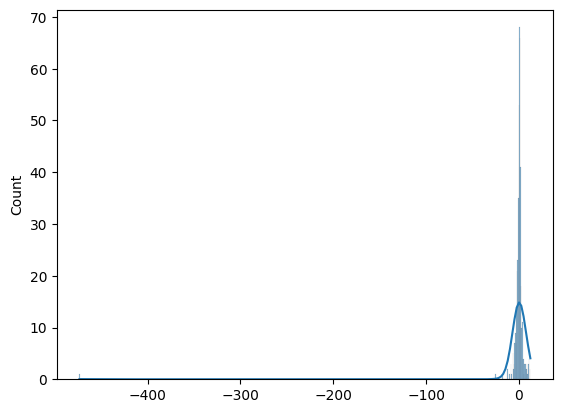

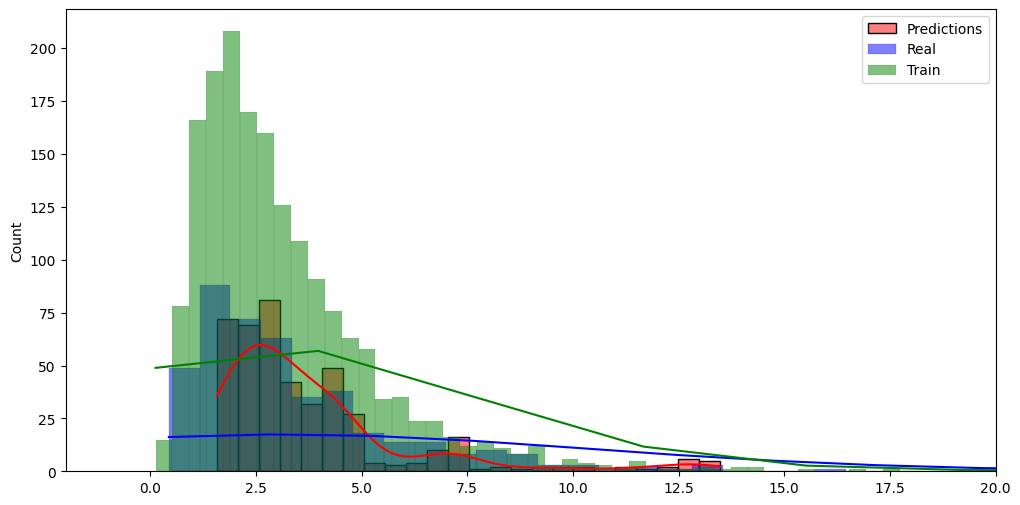

In [ ]:
import matplotlib.pyplot as plt
import seaborn as  sns

#histogram of the residuals
residuals = (preds.mean - test_y).cpu().numpy()
sns.histplot(residuals, kde=True)

fig = plt.figure(figsize=(12, 6))
# preds vs real histogram

sns.histplot(preds.mean.cpu().numpy(), color='r', kde=True, label='Predictions')
sns.histplot(test_y.cpu().numpy(), color='b', kde=True, label='Real')

#train histogram
sns.histplot(train_y.cpu().numpy(), color='g', kde=True, label='Train')

# xlim 
plt.xlim(-2, 20)
plt.legend()